In [1]:
!git clone https://github.com/openai/CLIP.git

fatal: destination path 'CLIP' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/CompVis/taming-transformers

fatal: destination path 'taming-transformers' already exists and is not an empty directory.


In [3]:
## install some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

In [4]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip

In [5]:
## helper functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters
learning_rate = .5
batch_size = 1
wd = .1
noise_factor = .22
total_iter=400
show_step = total_iter - 1
im_shape = [450, 450, 3] # height, width, channel
size1, size2, channels = im_shape


In [6]:
### CLIP MODEL ###
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [7]:
## Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


/content/taming-transformers


In [8]:
from taming.models.vqgan import VQModel

def load_config(config_path,display = False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data


def load_vqgan(config,chk_path = None):
  model = VQModel(**config.model.params)

  if chk_path is not None:
    state_dict = torch.load(chk_path , map_location = "cpu")["state_dict"]
    missing,unexpected = model.load_state_dict(state_dict, strict = False)
  return model.eval()


def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x


In [9]:
taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [10]:
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters,self).__init__()
    self.data = 0.5 * torch.randn(batch_size,256,size1//16,size2//16).cuda()
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

In [11]:
def init_params():
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr':learning_rate}],weight_decay=wd)
  return params,optimizer

In [12]:
def encode_text(t):
  t = clip.tokenize(t).cuda()
  t = clipmodel.encode_text(t).detach().clone()
  return t

In [13]:
def createEncoding(include,exclude,extras):
  include_enc = []
  for t in include:
    include_enc.append(encode_text(t))
  exclude_enc = encode_text(exclude)if exclude != '' else 0
  extras_enc = encode_text(extras)if extras != '' else 0
  return include_enc,exclude_enc,extras_enc

In [14]:
params,optimizer = init_params()

In [15]:
augTransformation = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2,.2), fill =0)
).cuda()

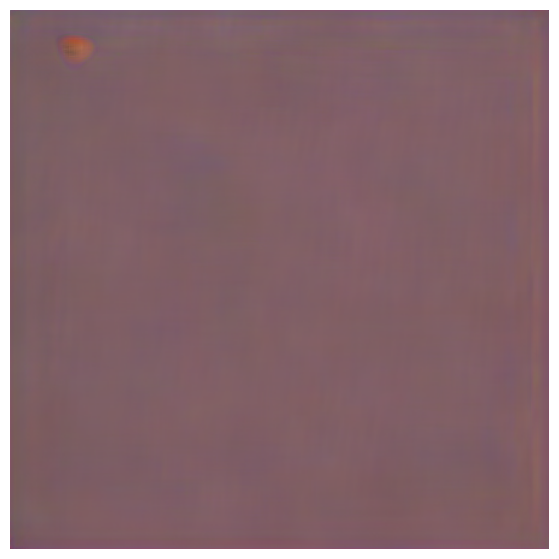

In [16]:
with torch.no_grad():
  img = norm_data(generator(params()).cpu())
  show_from_tensor(img[0])

In [17]:
def create_crop(img, show_crop = 32):
  p = size1 // 2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode = 'constant', value = 0)
  img = augTransformation(img)
  crop_set = []

  for crop in range(show_crop):
    gap1 = int(torch.normal(1.2,.3,()).clip(.43,1.9) * size1)
    offsetx = torch.randint(0, int(size1*2 - gap1),())
    offsety = torch.randint(0, int(size1*2 - gap1),())
    crop = img[:,:,offsetx:offsetx+gap1,offsety:offsety+gap1]
    crop = torch.nn.functional.interpolate(img, [224,224], mode = 'bilinear', align_corners= True)
    crop_set.append(crop)

  crops = torch.cat(crop_set, 0)
  randnormal = torch.randn_like(crops, requires_grad=False)
  randtotal = torch.rand((crops.shape[0],1,1,1)).cuda()

  numrand = 0

  for ns in range(numrand):
    randtotal *= torch.rand((crops.shape[0],1,1,1)).cuda()

  crops = crops + noise_factor * randtotal * randnormal
  return crops

In [18]:
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

In [19]:
def optimize_result(params, prompt):
  alpha = 1
  beta = 0.5

  img = generator(params())
  img = norm_data(img)
  img = create_crop(img)
  img = normalize(img)
  img_enc = clipmodel.encode_image(img)

  final_enc = w1 * prompt + w2 * extras_enc
  final_include_enc = final_enc / final_enc.norm(dim = -1 , keepdim = True)
  final_exclude_enc = exclude_enc

  main_loss = torch.cosine_similarity(final_include_enc,img_enc, -1)
  penalize_loss = torch.cosine_similarity(final_exclude_enc, img_enc, -1)

  loss = -alpha * main_loss + beta * penalize_loss
  return loss


def optimize(params, prompt, optimizer):
  loss = optimize_result(params,prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss



def showme(params, show_crop):
  with torch.no_grad():
    generated = generator(params())

    if show_crop:
      aug_img = generated.float()
      aug_img = create_crop(aug_img,1)
      aug_img = norm_data(aug_img[0])
      show_from_tensor(aug_img)

    latest = norm_data(generated.cpu())
    show_from_tensor(latest[0])
    return latest[0]

In [20]:
def train(params,optimizer,show_crop):
  res_img = []
  res_z = []

  for prompt in include_enc:
    iteration = 0
    params, optimizer = init_params()

    for it in range(total_iter):
      loss = optimize(params,prompt,optimizer)

      if iteration >= 80 and iteration % show_step == 0:
        img = showme(params, show_crop)
        res_img.append(img)
        res_z.append(params())
        print(f"loss:{loss.item()} Iteration:{iteration}")

      iteration += 1

    torch.cuda.empty_cache()

  return res_img, res_z

In [ ]:
torch.cuda.empty_cache()
# include=['sketch of a lady', 'sketch of a man on a horse']
include=['A painting of a pineapple in a bowl']
exclude='watermark'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncoding(include, exclude, extras)
res_img, res_z = train(params, optimizer, show_crop=True)
